# Model 3


In [2]:
# Model


# C = concentration of a particular ion. this will be evaporite corrected (uMol/L)

# C_0 = concentration of rainwater for that particular ion (uMol/L)

# C_eq = max concentration of this particular ion (uMol/L)

# A = Specific surface area = 0.1 (m^2/g)

# Xr = Mineral concentration in rock = 0.36 (unitless, g/g)

# Rho_sf = Mass mineral / fluid volume ratio = density_feldspar/porosity = 2.23/porosity (g/cm^3)

# k = reaction rate (mol/m^2/s)

# T_eq = equilibration time (s). Can take a guess at the start, say 100 years and see

# T_res = residence time, what we want to figure out

In [3]:
# a = 1

# b = -C_eq / ((A*Xr*Rho_sf*k) * ln((C-Ceq)/(Co-Ceq)))

# c = -C_eq * T_eq /(A*Xr*Rho_sf*k) * ln((C-Ceq)/(Co-Ceq))

# T_res = (-b + sqrt(b^2 - 4ac)) / 2a


In [4]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from geopy.distance import geodesic
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs


In [5]:
df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Trav_3_data_Final.xlsx')

df_copy = df.copy()

In [6]:
# define an element dictionary
from scipy.spatial import cKDTree

elements = {'Na_mM_EC', 'Ca_mM_EC', 'Mg_mM_EC', 'Si_mM_EC', 'K_mM_EC', 'Al_mM_EC'}

elements_rain = {'Na_mM', 'Ca_mM', 'Mg_mM', 'Si_mM', 'K_mM', 'Al_mM'}


df_traverse3 = df_copy[df_copy['Traverse'] == 'Traverse 3']

# Calculate C_eq as the maximum concentration for each element in df_traverse3
C_0 = {element: df_traverse3[element].min() for element in elements}

for element in elements:
    df_traverse3[f'C_0_{element}'] = C_0[element]


In [13]:
from geopy.distance import geodesic

# Assuming df_copy is your DataFrame with 'Latitude' and 'Longitude' columns
ridge_longitude = 86.62  # Longitude of the ridge crest

# Function to calculate horizontal distance from the ridge crest at the same latitude
def calculate_ridge_distance(lat, lon):
    # The reference point at the same latitude as the given point, with the ridge longitude
    reference_point = (lat, ridge_longitude)
    point = (lat, lon)  # Using the same latitude but varying the longitude
    distance = geodesic(reference_point, point).kilometers
    return distance

# Apply the function to each row and add 'ridge distance' column to df_copy
df_traverse3['ridge distance'] = df_copy.apply(lambda row: calculate_ridge_distance(row['Latitude'], row['Longitude']), axis=1)


In [7]:
# Calculate C_eq as the maximum concentration for each element in df_traverse3
C_eq = {element: df_traverse3[element].max() for element in elements}

for element in elements:
    df_traverse3[f'C_eq_{element}'] = C_eq[element]

# print the first 5 rows of C_eq_element
print(df_traverse3[[f'C_eq_{element}' for element in elements]].head())


   C_eq_Si_mM_EC  C_eq_Na_mM_EC  C_eq_Al_mM_EC  C_eq_K_mM_EC  C_eq_Ca_mM_EC  \
0       0.437546       0.251491        0.00065      0.023632       0.117019   
1       0.437546       0.251491        0.00065      0.023632       0.117019   
2       0.437546       0.251491        0.00065      0.023632       0.117019   
3       0.437546       0.251491        0.00065      0.023632       0.117019   
4       0.437546       0.251491        0.00065      0.023632       0.117019   

   C_eq_Mg_mM_EC  
0       0.023028  
1       0.023028  
2       0.023028  
3       0.023028  
4       0.023028  


In [8]:

# # Function to calculate T_res
# def calculate_T_res(C, C_0, C_eq):
#     if C_eq - C_0 == 0 or C_eq - C == 0:
#         return np.nan, np.nan, np.nan  # Ensure all three values are returned

#     ln_term = np.log((C_eq - C_0)/ (C_eq - C))
    
    
#     denominator = A_a * X_r * rho_sf * k

#     b = - C_eq * ln_term / denominator
#     c = - C_eq * T_eq * ln_term / denominator 

#     discriminant = b**2 - 4 * c

#     if discriminant < 0:
#         return np.nan, discriminant, np.nan  # Ensure three outputs

#     T_res = (-b + np.sqrt(discriminant)) / 2
    
#     T_res_yr = T_res / 31556952000000  # Convert seconds to years
    
#     return T_res_yr, discriminant, b

# # Apply calculation to each element in df_traverse3
# for element in elements:
#     df_T_res = df_traverse3.apply(
#         lambda row: pd.Series(calculate_T_res(row[element], row[f'C_0_{element}'], row[f'C_eq_{element}'])), axis=1
#     )

#     df_T_res.columns = [f'T_res_{element}', f'Discriminant_{element}', f'b_{element}']

#     df_traverse3 = pd.concat([df_traverse3, df_T_res], axis=1)

# Model 4


In [9]:
A_a = 0.1  # Specific surface area (m^2/g)

X_r = 0.36  # Mineral concentration in rock (unitless, g/g)

rho_sf = 2.23 / 0.3  # Mass mineral / fluid volume ratio (g/cm^3), assuming porosity = 0.3 [for now]

k = 10**(-16) # Reaction rate (mol/m^2/s)

T_eq = 25 * 365 * 24 * 3600 * 10**6 # Equilibration time (s), assuming 25 years

# T_res will come out in 10^-6 s
# so to get T_res in seconds, we need to divide by 10^-9



In [10]:
from scipy.special import lambertw

def compute_t(a, b, c):
    
    e2 = np.exp(2)
    ln2 = np.log(2)
    
    argument = -a*b*c/((a+1)*e2)
    
    # print a, b, c, argument
    print('Argument:', argument)
    print('a:', a)
    print('b:', b)
    print('c:', c)
    
    W_value = lambertw(argument).real  # Extract real part in case of complex output
    t = (T_eq/(5*ln2)) * W_value
    return t

# Example values

# a = ln((C-Ceq)/(Co-Ceq))

# b = -Rd/Ceq

# c = T_eq

# Function to calculate T_res
def calculate_T_res_Model4(C, C_0, C_eq, A_a, X_r, rho_sf, k, T_eq):
    if C_eq - C_0 == 0 or C_eq - C == 0:
        return np.nan, np.nan, np.nan  # Ensure all three values are returned


    # how to write e**2 in python?
    e2 = np.exp(2)

    a = C / (C_eq*e2)
    
    R_d = A_a * X_r * rho_sf * k  # Ensure all these values are properly initialized
    b = C_eq /R_d
    
    ln2 = np.log(2)
    
    c = -5*ln2/T_eq

    T_res = compute_t(a, b, c)
    
    
    if isinstance(T_res, (list, tuple, np.ndarray)):
        T_res = T_res[0]  # Extract the first value if it's an array

    if not np.isscalar(T_res) or np.isnan(T_res):
        return np.nan  # Ensure we return a single number

    T_res_yr = T_res / 31556952000000  # Convert seconds to years
    return float(T_res_yr)  # Ensure it's a float

# Apply calculation to each element in df_traverse3
for element in elements:
    col_name = f'T_res_{element}'
    df_traverse3[f'T_res_{element}'] = df_traverse3.apply(
        lambda row: calculate_T_res_Model4(
            row[element], row[f'C_0_{element}'], row[f'C_eq_{element}'],
            A_a, X_r, rho_sf, k, T_eq
        ), axis=1
    )



Argument: 0.5481520290185218
a: 0.05971633425946999
b: 1.6350748115439772e+16
c: -4.3959105819377555e-15
Argument: 0.6063695701780305
a: 0.06648025942864869
b: 1.6350748115439772e+16
c: -4.3959105819377555e-15
Argument: 0.5070539098626134
a: 0.05499283803410085
b: 1.6350748115439772e+16
c: -4.3959105819377555e-15
Argument: 0.5226098897321245
a: 0.056775759494368035
b: 1.6350748115439772e+16
c: -4.3959105819377555e-15
Argument: 0.6712840620789593
a: 0.07412480572644094
b: 1.6350748115439772e+16
c: -4.3959105819377555e-15
Argument: 0.5136911900475877
a: 0.05575282194697316
b: 1.6350748115439772e+16
c: -4.3959105819377555e-15
Argument: 0.5254530101102554
a: 0.05710227031789802
b: 1.6350748115439772e+16
c: -4.3959105819377555e-15
Argument: 0.45563519937587693
a: 0.049142142338033185
b: 1.6350748115439772e+16
c: -4.3959105819377555e-15
Argument: 0.7643451875263222
a: 0.08527715062387758
b: 1.6350748115439772e+16
c: -4.3959105819377555e-15
Argument: 0.8825504985709135
a: 0.099781103794084
b:

In [11]:
print("T_res Range for Each Element:")
for element in elements:
    col_name = f'T_res_{element}'
    
    # Drop NaNs and ensure the column is numeric
    T_res_series = pd.to_numeric(df_traverse3[col_name], errors='coerce').dropna()

    if not T_res_series.empty:
        T_res_min = T_res_series.min()
        T_res_max = T_res_series.max()
        print(f"Element: {element}, T_res range: {T_res_min:.2f} to {T_res_max:.2f} years")
    else:
        print(f"Element: {element}, No valid T_res values available")


T_res Range for Each Element:
Element: Si_mM_EC, T_res range: 1.51 to 4.22 years
Element: Na_mM_EC, T_res range: 0.27 to 2.66 years
Element: Al_mM_EC, T_res range: -0.01 to 0.01 years
Element: K_mM_EC, T_res range: 0.04 to 0.40 years
Element: Ca_mM_EC, T_res range: -0.11 to 1.47 years
Element: Mg_mM_EC, T_res range: 0.07 to 0.39 years


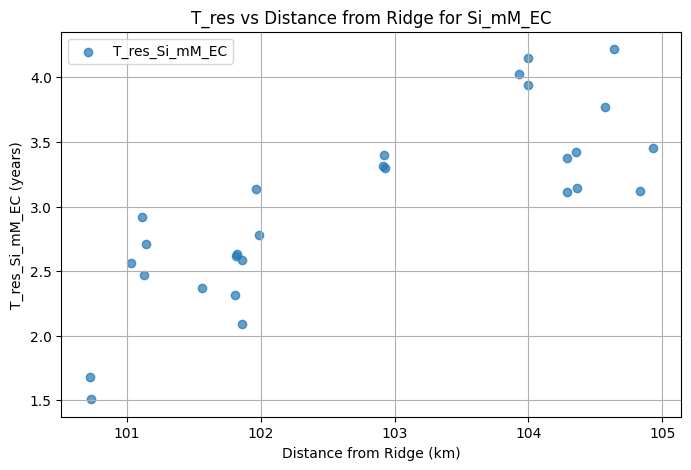

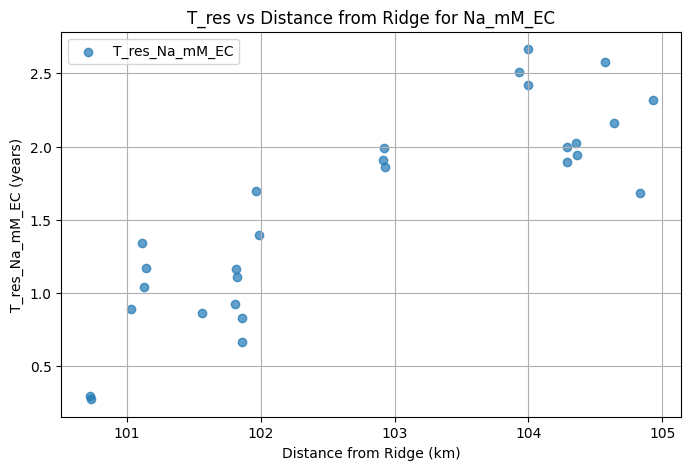

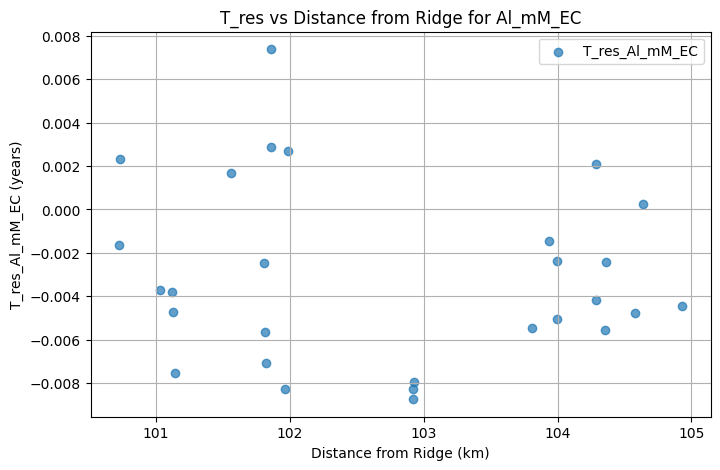

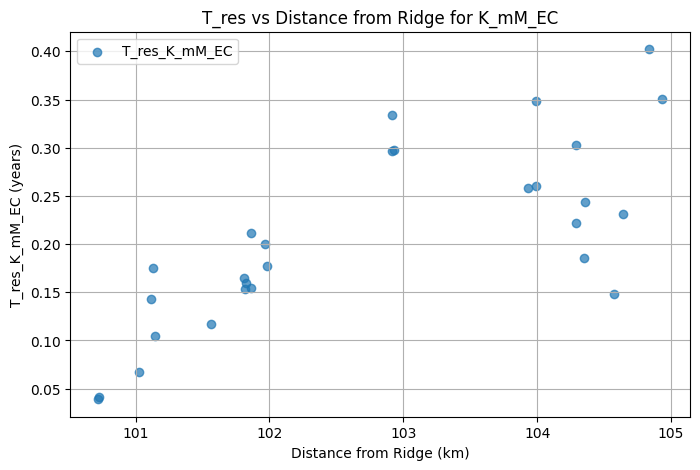

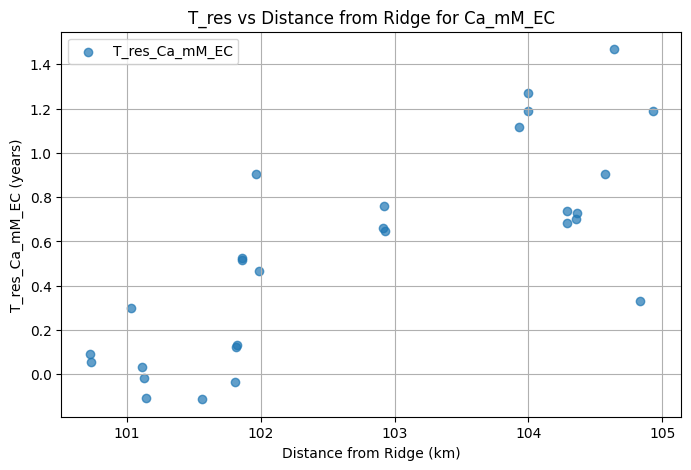

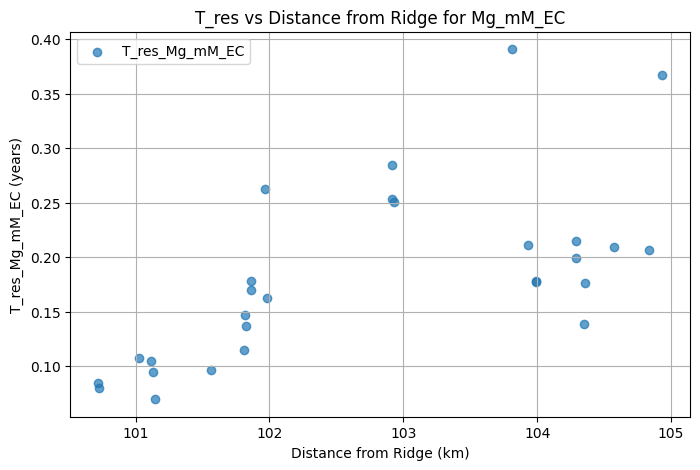

In [15]:
#Create individual plots for each element
for element in elements:
    plt.figure(figsize=(8, 5))
    df_traverse3[f"T_res_{element}"] = pd.to_numeric(df_traverse3[f"T_res_{element}"], errors='coerce')

    plt.scatter(df_traverse3["ridge distance"], df_traverse3[f"T_res_{element}"], alpha=0.7, label=f"T_res_{element}")
    plt.xlabel("Distance from Ridge (km)")
    plt.ylabel(f"T_res_{element} (years)")
    plt.title(f"T_res vs Distance from Ridge for {element}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'T_res_Distance{element}.pdf')
    plt.show()
    plt.close()
    
    
length = 4000
porosity = 0.3

for element in elements:
    df_traverse3[f"Flow_rate_myr_{element}"] = length * porosity / df_traverse3[f"T_res_{element}"]
    df_traverse3[f"Flow_rate_mys_{element}"] = df_traverse3[f"Flow_rate_myr_{element}"] / (3.15576e7)
    
    plt.figure(figsize=(8, 5))
    
    plt.scatter(df_traverse3["Elevation"], df_traverse3[f"Flow_rate_mys_{element}"], alpha=0.7, label=f"T_res_{element}")
    plt.xlabel("Elevation (m)")
    plt.ylabel(f"Flow_rate_{element} (years)")
    plt.title(f"Flow rate vs Elevation for {element}")
    plt.legend()
    plt.grid(True)
    #plt.show()
    plt.close()
    
    
